In [1]:
# Import Libraries
import os
import cv2
import scipy
import numpy as np
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.applications import InceptionResNetV2
from keras.models import Sequential, Model
from keras.layers import  Dropout,Dense,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# File Paths
input_path = "../input/chest-xray-pneumonia/chest_xray/"

In [3]:
# File Contents
for _set in ['train', 'val', 'test']:
    normal = len(os.listdir(input_path + _set + '/NORMAL'))
    infected = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('The {} folder contains {} Normal and {} Pneumonia images.'.format(_set, normal, infected))

The train folder contains 1341 Normal and 3875 Pneumonia images.
The val folder contains 8 Normal and 8 Pneumonia images.
The test folder contains 234 Normal and 390 Pneumonia images.


In [4]:
# Preprocesing Data Function
def preprocess_data(input_path, img_dims, batch_size):
    
    # Data Augmentation for Train & Test Images
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        zoom_range = 0.2,
        shear_range = 0.2,      
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True)

    test_datagen = ImageDataGenerator(
        rescale = 1./255)
    
    train_images = train_datagen.flow_from_directory(
        directory = input_path + 'train', 
        target_size = (img_dims, img_dims), 
        batch_size = batch_size, 
        class_mode = 'binary', 
        shuffle = True)

    test_images = test_datagen.flow_from_directory(
        directory = input_path + 'test', 
        target_size = (img_dims, img_dims), 
        batch_size = batch_size, 
        class_mode = 'binary', 
        shuffle = True)

    # I'm created these lists for make prediction on test image and showing confusion matrix.
    train_labels = []
    test_labels = []

    for file_name in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + file_name)):
            img = plt.imread(input_path + 'test' + file_name+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if file_name == '/NORMAL/':
                label = 0
            elif file_name == '/PNEUMONIA/':
                label = 1
            train_labels.append(img)
            test_labels.append(label)
        
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    
    return train_images, train_labels, test_images, test_labels

In [5]:
img_dims = 150
epochs = 25
batch_size = 32

# Set Images&Labels for Train,Test
train_images, train_labels, test_images, test_labels = preprocess_data(input_path, img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# Set Transfer Model
transfer_model = InceptionResNetV2(weights= 'imagenet', include_top = False, input_shape = (img_dims, img_dims, 3))

219062272/219055592 [==============================] - 3s 0us/step


In [7]:
# Add new Layers
new_model = Sequential()
new_model.add(GlobalAveragePooling2D(input_shape = transfer_model.output_shape[1:], data_format=None)),  
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(1, activation='sigmoid'))

In [8]:
# Combine Models
model = Model(inputs=transfer_model.input, outputs=new_model(transfer_model.output))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [9]:
# Set Optimizer
optimizer = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08,decay = 0.0)

# Compile Model
model.compile(
    optimizer= optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])

In [10]:
# Fit the Model
history = model.fit_generator(
            train_images,
            steps_per_epoch = train_images.samples // batch_size, 
            epochs = epochs, 
            validation_data = test_images,
            validation_steps = test_images.samples // batch_size)

Epoch 1/25
163/163 [==============================] - 327s 2s/step - loss: 0.2117 - acc: 0.9072 - val_loss: 0.7896 - val_acc: 0.6760
Epoch 2/25
163/163 [==============================] - 201s 1s/step - loss: 0.1165 - acc: 0.9569 - val_loss: 0.3478 - val_acc: 0.8530
Epoch 3/25
163/163 [==============================] - 188s 1s/step - loss: 0.0944 - acc: 0.9672 - val_loss: 0.5802 - val_acc: 0.8446
Epoch 4/25
163/163 [==============================] - 188s 1s/step - loss: 0.0804 - acc: 0.9724 - val_loss: 0.2370 - val_acc: 0.9409
Epoch 5/25
163/163 [==============================] - 186s 1s/step - loss: 0.0601 - acc: 0.9783 - val_loss: 0.1379 - val_acc: 0.9257
Epoch 6/25
163/163 [==============================] - 185s 1s/step - loss: 0.0557 - acc: 0.9781 - val_loss: 0.4116 - val_acc: 0.9341
Epoch 7/25
163/163 [==============================] - 184s 1s/step - loss: 0.0464 - acc: 0.9814 - val_loss: 0.3938 - val_acc: 0.9358
Epoch 8/25
163/163 [==============================] - 185s 1s/step - 

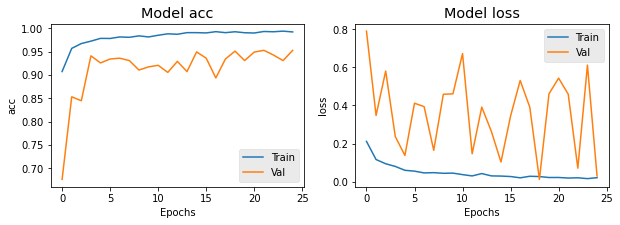

In [11]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    plt.style.use("ggplot")
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['Train', 'Val'])

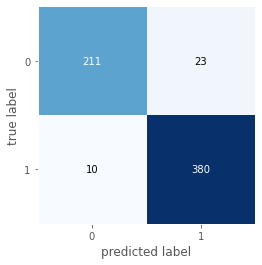

Confusion Matrix :
[[211  23]
 [ 10 380]]
Accuracy Score : 0.9471153846153846
Report : 
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       234
           1       0.94      0.97      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.94       624
weighted avg       0.95      0.95      0.95       624



In [12]:
# Predictions, Confusion Matrix & Performance Metrics

# Prediction on Model
Y_pred = model.predict(train_labels)
Y_pred = [ 1 if y >= 0.5 else 0 for y in Y_pred]

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, Y_pred)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

# Performance Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',accuracy_score(test_labels, Y_pred))
print('Report : ')
print(classification_report(test_labels, Y_pred))

In [13]:
from keras.preprocessing.image import image

# Image Classifer Script
def predict_image(model, img_path, img_dims = 150):
    img = image.load_img(img_path, target_size = (img_dims, img_dims))
    plt.imshow(img)
    plt.show()
    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0) * 1./255
    score = model.predict(x)
    print('Predictions: ', score, 'NORMAL' if score < 0.5 else 'PNEUMONIA')

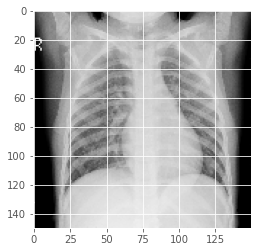

Predictions:  [[0.00508123]] NORMAL


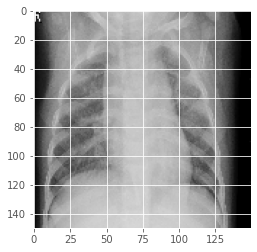

Predictions:  [[0.92370313]] PNEUMONIA


In [14]:
# Test on Validation Images
predict_image(model,(input_path+'val/NORMAL/NORMAL2-IM-1431-0001.jpeg'))
predict_image(model,(input_path+'val/PNEUMONIA/person1947_bacteria_4876.jpeg'))

In [15]:
# Save Model
model.save("InceptionResnetV2-Transfer-Model-Pneumonia.h5")